In [1]:
import numpy as np
import os

from scipy.spatial import distance
import pandas as pd
import matplotlib.pyplot as plt    
import networkx as nx
import copy
from scipy import stats
from copy import deepcopy
import time
import seaborn as sns

from scipy.optimize import curve_fit

import leidenalg
import igraph as ig

In [2]:
df = pd.read_csv("traced-total-connections.csv")
df

,bodyId_pre,bodyId_post,weight
0,294437328,295470623,1
1,294437328,295133902,1
2,294437328,448260940,1
3,294437328,294783423,1
4,294437328,5812979995,1
...,...,...,...
3550398,5901222127,546307807,1
3550399,5901222127,577697202,1
3550400,5901222127,393210919,1
3550401,5901222127,330640044,5


In [3]:
nodeA_list = df.bodyId_pre.tolist()
nodeB_list = df.bodyId_post.tolist()
weight_list = df.weight.tolist()

In [4]:
nodes = list(set(nodeA_list+nodeB_list))

In [5]:
%%time

#nodes_list = []
#for i in ra:
    #node attribute is given by its neuron name
#    nodes_list.append((i)

# creating an edge list from adjacency matrix
edge_list=[]
for i,j,w in zip(nodeA_list, nodeB_list, weight_list):
    edge_list.append( (i,j,{"weight":w}))#, "Label":"%s - %s"%(nodes[i],nodes[j])}  ))

G = nx.DiGraph()

# Add all the nodes to the graph
G.add_nodes_from(nodes)
# Add all the edges to the graph
G.add_edges_from(edge_list)

CPU times: user 10.9 s, sys: 1.04 s, total: 11.9 s
Wall time: 11.9 s


# Network properties

In [6]:
G.is_directed()

True

In [7]:
nx.is_weakly_connected(G)

True

In [8]:
G.number_of_nodes()

21739

In [9]:
G.number_of_edges()

3550403

In [10]:
%%time
print("Network density: ", nx.density(G))

Network density:  0.007513088504789194
CPU times: user 12.3 ms, sys: 142 µs, total: 12.5 ms
Wall time: 12.5 ms


In [ ]:
%%time
avg_cluster_unw = nx.average_clustering(G)
print("Avg. Clustering coeff. (unweighted): ", avg_cluster_unw)

In [ ]:
%%time
avg_cluster_w = nx.average_clustering(G, weight="weight")
print("Avg. Clustering coeff. (Weighted): ", avg_cluster_w)

In [ ]:
%%time
diam = nx.average_shortest_path_length(G)
print("Path length (Unweighted): ", diam)

In [ ]:
%%time
diam_w = nx.average_shortest_path_length(G, weight="weight")
print("Path length (Weighted): ", diam_w)

In [ ]:
# Assortativity
def logKnn(logK, mu, c):
    return mu*logK + c


def plotnfit_Knn(G, degree_direction_source,degree_direction_target):
    """Plots a log-log scatter plot of Knn(k) vs k and also does fitting. 
    Parameters
    ----------
    G : Networkx graph
       A graph
    degree_direction: str, 'in'-> in-degree K_in, 'out'-> out-degree K_out
    """
    knn = nx.k_nearest_neighbors(G, source=degree_direction_source,
                                 target=degree_direction_target,weight='weight')
    
    # Extract Knn(K) and K
    k = np.array(list(knn.keys()))
    #print(max(k))
    knn_k = np.array(list(knn.values()))

    # remove zeros from Knn, clean the data since we are applying log function.
    knn_new = knn_k[knn_k>0]
    k_new = k[knn_k>0]

    # apply log to do log fitting instead of power law fitting
    x = np.log(k_new)
    y = np.log(knn_new)
    params,cov = curve_fit(logKnn,x,y) # cov is the covariance matrix
    mu = params[0]
    c = params[1]

    yfit = logKnn(x,*params)
    
    plt.figure(figsize=(8,6))
    plt.plot(k,knn_k,'.')
    plt.axhline(y=np.mean(knn_k),c='black',lw=0.95,linestyle='-',label='neutral behaviour')
    plt.plot(np.exp(x),np.exp(yfit),'--',lw=2.3,dashes=[3,6],label='$\\sim k^{%.3f}$'%(mu))#,degree_direction_source))
    
    
    plt.yscale('log')
    plt.xscale('log')
    
    
    # aesthetics
    plt.tick_params(direction='in',bottom=True,top=True,left=True,right=True)
    plt.grid(linestyle='--',alpha=0.5,which='both')
    plt.legend(loc='lower right',prop={'size': 15.5})

    plt.xlabel(degree_direction_source+"-degree, $k_{%s}$"%degree_direction_source,size=15)
    plt.ylabel("$k_{nn}(k_{%s})$"%degree_direction_target,size=15)
    plt.title('%s-assortativity plot of $k_{nn}(k_{%s})$ \nand fit $k_{nn}(k_{%s}) = C  k^{\mu}_{%s}$'
              %(degree_direction_target,degree_direction_target,degree_direction_target,
                degree_direction_source),size=15)
    

    plt.savefig("%s-%s_degree_knnVsk.png"%(degree_direction_target,degree_direction_source), 
               facecolor="white", bbox_inches="tight", dpi=600)

    plt.show()

In [ ]:
%%time
plotnfit_Knn(G, "in", "in")

In [ ]:
%%time
plotnfit_Knn(G, "in", "out")

In [ ]:
%%time
plotnfit_Knn(G, "out", "out")

In [ ]:
%%time
plotnfit_Knn(G, "out", "in")

In [ ]:
# Degree distribution

def plot_constbin(degree):
    degree = np.array(degree) # if list convert to np array
    deg = degree[degree>0] # don't consider values=0

    edges= np.histogram_bin_edges(deg,bins='auto')
    pk = np.array(plt.hist(deg,bins=edges,density=True))[0]

    plt.close()

    edges2 = list(edges[1:])+[0]

    mid_point = (np.array([a+b for a,b in zip(edges,edges2)])/2)[:-1]
    #print("Constant automated binning:")
    #print("first 5 bin edges:",edges[:5])
    #print("first 5 pk(as density instead of counts), y values:",pk[:5])
    #print("first 5 mid-point of bin edges, x values:",mid_point[:5])
    #print("min(K_out): ",min(out_deg))
    plt.figure(figsize=(8,6))
    
    plt.loglog(mid_point, pk,'o', alpha=0.7,color="orangered")
    
    plt.xlabel("k",size=16)
    plt.ylabel("$P(k)$",size=16)
    plt.title("log-log plot with automated \n optimized x-axis binning, bin size = %.2f"%(edges[1]-edges[0]),
              size=14)
    print("bin size: ",(edges[1]-edges[0]))
    plt.tick_params("x", labelsize="14")
    plt.tick_params("y", labelsize="14")
    
    plt.tick_params(direction='in',bottom=True,top=True,left=True,right=True)
    #plt.grid(linestyle='--',alpha=0.5,which='both')
    


In [ ]:
# in degree distribution

in_deg =  list(dict(G.in_degree(G.nodes, weight='weight')).values())
plot_constbin(in_deg)
plt.savefig("weighted_in_degree_distribution.png", facecolor="white", bbox_inches="tight", dpi=600)

In [ ]:
# out degree distribution
out_deg = list(dict(G.out_degree(G.nodes, weight='weight')).values())
plot_constbin(out_deg)
plt.savefig("weighted_out_degree_distribution.png", facecolor="white", bbox_inches="tight", dpi=600)

# Leiden Community detection

In [ ]:
%%time

# convert to ig graph
G_ig = ig.Graph.from_networkx(G)

In [ ]:
%%time
dir_leiden = leidenalg.find_partition(G_ig, leidenalg.ModularityVertexPartition, weights="weight")

In [ ]:
# number of communities

len(set(dir_leiden.membership))

In [ ]:
from collections import Counter

In [39]:
Counter(dir_leiden.membership)

Counter({1: 3997, 0: 6007, 6: 935, 3: 2956, 2: 3177, 4: 2350, 5: 2317})

In [40]:
df_comm = pd.DataFrame({"node":G_ig.vs["_nx_name"], "community": dir_leiden.membership})

In [41]:
df_comm

,node,community
0,797442049,1
1,1098776577,0
2,1170866180,6
3,1629880348,0
4,1475477547,1
...,...,...
21734,1170866126,6
21735,1200619473,0
21736,1817444315,1
21737,7112622044,3


In [42]:
G.number_of_nodes()

21739

In [43]:
df_comm.to_csv("leiden_communities_drosophilia.csv", index=False)

# Cell type matrix representaion

In [2]:
df_neuron_info = pd.read_csv("traced-neurons.csv")

In [3]:
df_neuron_info

,bodyId,type,instance
0,200326126,CL141,CL141_L
1,202916528,FS4C,FS4C(FQ12)_C4_R
2,203253072,FS4A,FS4A(AB)(FQ12)_C3_R
3,203253253,SMP505,SMP505(PDM22)_L
4,203257652,FS4C,FS4C(FQ12)_C6_R
...,...,...,...
21734,7112579856,LC20,LC20
21735,7112615127,AVLP335,AVLP335_R
21736,7112617294,AVLP331,AVLP331_R
21737,7112622044,LAL137,LAL137(PVL05)_L


In [5]:
df_neuron_info = df_neuron_info.dropna()

In [8]:
len(df_neuron_info.type.unique())

5554

# Community detection Average 10,000 runs

In [61]:
def find_number_communities(graph):
    nComm = []
    for i in range(100):
        comm_membership = leidenalg.find_partition(graph, leidenalg.ModularityVertexPartition, weights="weight")

        nComm.append(len(np.unique(comm_membership.membership)))

    return Counter(nComm).most_common(1)[0][0]

In [62]:
global G_ig

G_ig = ig.Graph.from_networkx(G)

KeyboardInterrupt: 

In [ ]:
%%time

# Check for stability in number of communities

nComm = []
for i in range(10):
    comm_membership = leidenalg.find_partition(G_ig, leidenalg.ModularityVertexPartition, weights="weight")

    nComm.append(len(np.unique(comm_membership.membership)))
print(Counter(nComm))

In [ ]:
from concurrent.futures import ProcessPoolExecutor


In [ ]:
%%time

from concurrent.futures import ProcessPoolExecutor

def communities_loop(args):
    nreps, seed = args
    np.random.seed(seed)
    
    list_communities = []
    while len(list_communities) < nreps:
        dir_leiden = leidenalg.find_partition(G_ig, leidenalg.ModularityVertexPartition, weights="weight")
        if np.unique(dir_leiden.membership).size == 8:
            list_communities.append(dir_leiden.membership)

    return list_communities

nloops = 32
seeds = np.random.randint(0, int(1e6), size = nloops)

with ProcessPoolExecutor() as executor:
    parallel_res = executor.map(communities_loop,
                                zip([32]*nloops,
                                    seeds))
list_communities = []
for res in parallel_res:
    [list_communities.append(i) for i in res]

In [140]:
len(list_communities)

1024

In [25]:
def find_communities(list_communities, idx_communities):
    comm = []
    for idx in idx_communities:
        comm.append(np.where(np.array(list_communities) == idx)[0])
    return comm

def find_overlap(comm_check, comm_truth):
    overlap = np.zeros((len(comm_truth), len(comm_check)), dtype = np.float64)
    for i, comm_i in enumerate(comm_truth):
        for j, comm_j in enumerate(comm_check):
            overlap[i][j] = np.intersect1d(comm_i, comm_j).size/(comm_i.size + comm_j.size)
    return overlap

def relabel_communities(idx_comm, comm_truth, list_communities, idx_communities):
    old_comm_list = list_communities[idx_comm]
    overlap = find_overlap(find_communities(old_comm_list, idx_communities),
                           comm_truth)
    
    new_idxs = np.argmax(overlap, axis = 0)
    new_comm_list = np.empty(len(old_comm_list))
    
    for idx, old_val in enumerate(old_comm_list):
        new_comm_list[idx] = new_idxs[old_val]
    
    return new_comm_list

In [142]:
idx_communities = np.array(list(range(8))) # <- 8 is considered here!!!!
comm_truth = find_communities(list_communities[0], idx_communities)

In [143]:
%%time

relabeled_comm_list = []
for idx in range(len(list_communities)):
    relabeled_comm_list.append(relabel_communities(idx, comm_truth,
                                                   list_communities, idx_communities))
    
relabeled_comm_list = np.array(relabeled_comm_list).astype(np.int8)

CPU times: user 29.8 s, sys: 254 ms, total: 30 s
Wall time: 30 s


In [144]:
print(G.number_of_nodes())
print(relabeled_comm_list.shape)

21739
(1024, 21739)


In [145]:
relabeled_comm_list

array([[0, 1, 6, ..., 0, 2, 4],
       [0, 1, 7, ..., 0, 2, 4],
       [0, 6, 7, ..., 0, 2, 4],
       ...,
       [0, 1, 7, ..., 0, 2, 4],
       [0, 1, 7, ..., 0, 2, 4],
       [0, 1, 7, ..., 0, 2, 4]], dtype=int8)

In [146]:
final_communities = np.empty(relabeled_comm_list.shape[1])
for idx, rep in enumerate(relabeled_comm_list.T):
    final_communities[idx] = np.bincount(rep).argmax()
    
leiden_community_dict = dict(zip(list(G_ig.vs['_nx_name']), final_communities.astype(np.int8)))

In [147]:
final_communities

array([0., 1., 7., ..., 0., 2., 4.])

In [27]:
def Community_save(Graph, membership, filename):    
    df = pd.DataFrame()
    df['Node'] = Graph.vs['_nx_name']
    df['Community'] = membership
    #df['Name'] = Graph.vs['name']
    
    df.to_csv(filename+".csv", index=False)

    
    comm_num_list = df["Community"].unique().tolist()
    
    size_list = []
    for comm_num in comm_num_list:
        df_comm = df[df["Community"]==comm_num]
        #df_comm.to_csv(filename+str(comm_num)+".csv", index=False)
        size_list.append(len(df_comm))
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(comm_num_list,size_list)
    plt.xlabel("Community", size=15)
    plt.ylabel("Size", size=15)
    plt.title("No. of comm: %d"%len(comm_num_list))
    plt.show()

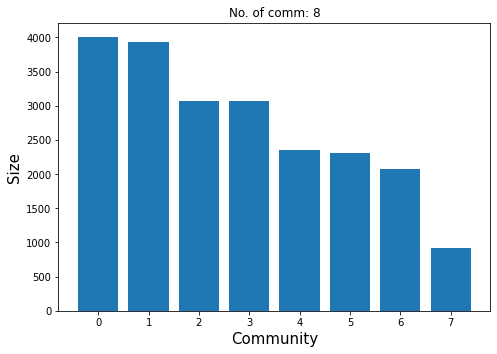

In [149]:
Community_save(G_ig, final_communities, "averageComm_drosophilia")

In [161]:
final_communities_all = np.array(pd.read_csv("averageComm_drosophilia.csv")["Community"].to_list())

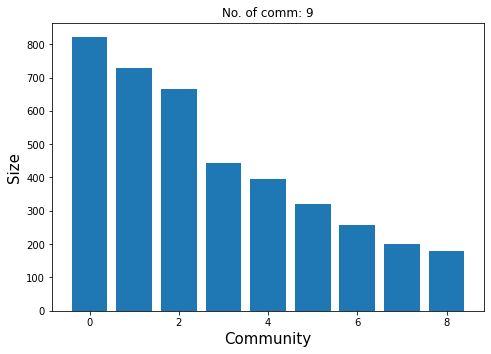

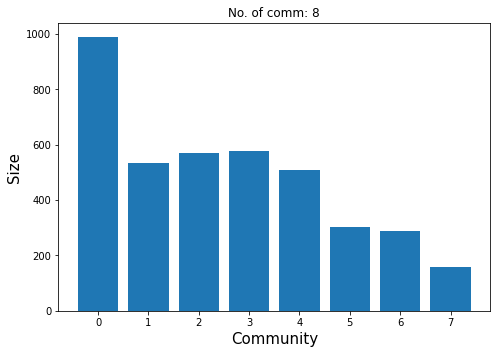

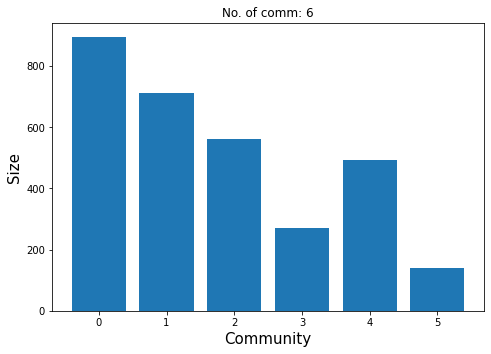

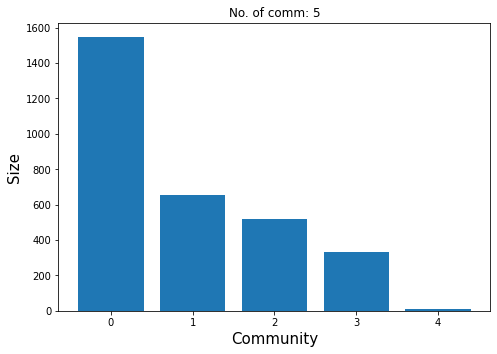

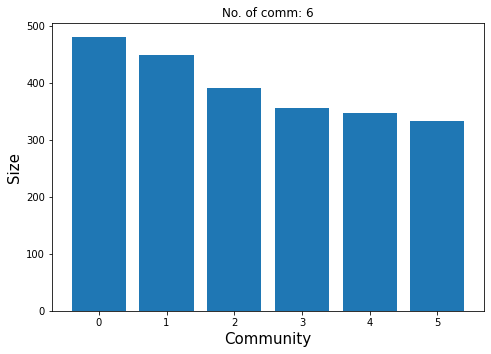

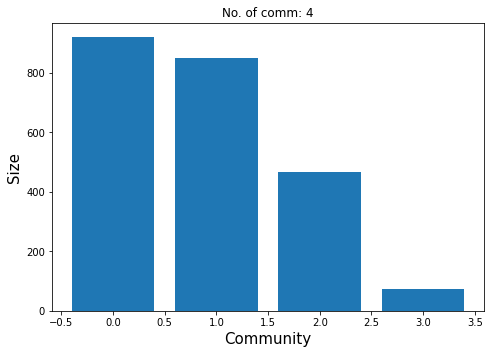

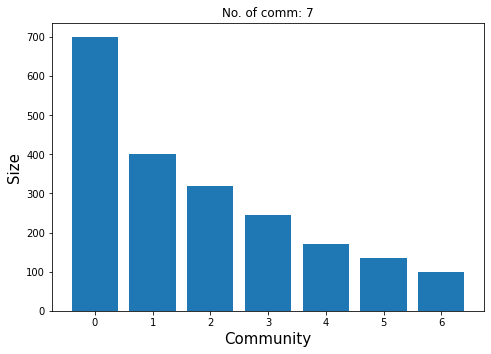

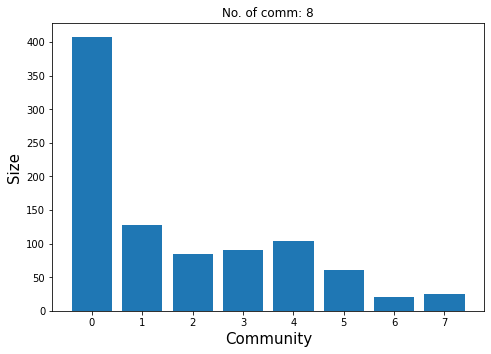

CPU times: user 5min 57s, sys: 41.5 s, total: 6min 38s
Wall time: 11min 30s


In [162]:
%%time
for idx_comm in range(8):
    
    global G_subgraph_ig
    global num_comm_tofind
    G_subgraph_ig = G_ig.subgraph(np.where(final_communities_all == idx_comm)[0])
    
    num_comm_tofind = find_number_communities(G_subgraph_ig)
    
    def subcommunities_loop(args):
        nreps, seed = args
        np.random.seed(seed)

        list_communities = []
        while len(list_communities) < nreps:
            dir_leiden = leidenalg.find_partition(G_subgraph_ig, leidenalg.ModularityVertexPartition, weights="weight")
            if np.unique(dir_leiden.membership).size == num_comm_tofind:
                list_communities.append(dir_leiden.membership)

        return list_communities

    nloops = 32
    seeds = np.random.randint(0, int(1e6), size = nloops)

    with ProcessPoolExecutor() as executor:
        parallel_res = executor.map(subcommunities_loop,
                                    zip([32]*nloops,
                                        seeds))
    list_communities = []
    for res in parallel_res:
        [list_communities.append(i) for i in res]
        
    idx_communities = np.array(list(range(num_comm_tofind)))
    comm_truth = find_communities(list_communities[0], idx_communities)
    
    relabeled_comm_list = []
    for idx in range(len(list_communities)):
        relabeled_comm_list.append(relabel_communities(idx, comm_truth,
                                                       list_communities, idx_communities))

    relabeled_comm_list = np.array(relabeled_comm_list).astype(np.int8)
    
    final_communities = np.empty(relabeled_comm_list.shape[1])
    for idx, rep in enumerate(relabeled_comm_list.T):
        final_communities[idx] = np.bincount(rep).argmax()
    
    Community_save(G_subgraph_ig, final_communities, f"averageSubComm{idx_comm}_drosophilia")

# Leiden Community connectivity matrix

In [6]:
df_dir = pd.read_csv("./EM_communities/averageComm_drosophilia.csv")
cmt_num_dir = sorted(df_dir.Community.unique().tolist())

ncomm_dir = len(cmt_num_dir)

In [7]:
ncomm_dir

8

In [8]:
%%time

comm_connnectivity_array = []

for i in cmt_num_dir:
    
    df_i = df_dir.groupby("Community").get_group(i)

    nodes_Cmt1 = df_i.Node.tolist()
    
    for j in cmt_num_dir:
        
        df_j = df_dir.groupby("Community").get_group(j)
        
        nodes_Cmt2 = df_j.Node.tolist()
        
        count=0
        for i in nodes_Cmt1:
            for j in nodes_Cmt2:
                if G.has_edge(i, j):
                    count+=1
        comm_connnectivity_array.append(count)            
        

comm_connnectivity_array = np.array(comm_connnectivity_array).reshape((ncomm_dir, ncomm_dir))        
    



CPU times: user 1min 45s, sys: 18 ms, total: 1min 45s
Wall time: 1min 45s


In [9]:
np.diag(np.diag(comm_connnectivity_array))

array([[487490,      0,      0,      0,      0,      0,      0,      0],
       [     0, 291025,      0,      0,      0,      0,      0,      0],
       [     0,      0, 407107,      0,      0,      0,      0,      0],
       [     0,      0,      0, 387484,      0,      0,      0,      0],
       [     0,      0,      0,      0, 371690,      0,      0,      0],
       [     0,      0,      0,      0,      0, 542167,      0,      0],
       [     0,      0,      0,      0,      0,      0, 141804,      0],
       [     0,      0,      0,      0,      0,      0,      0,  77704]])

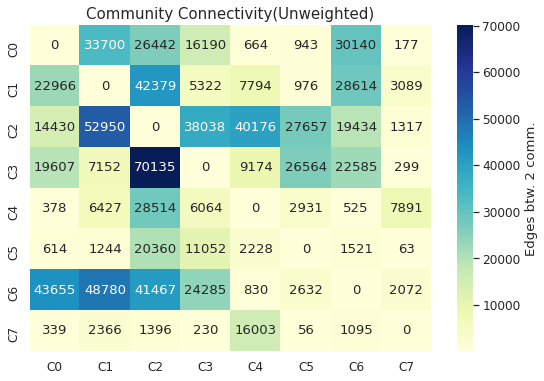

In [14]:
plt.figure(figsize=(9,6))

#sns.heatmap(comm_connectivity_array  , cmap="YlGnBu")
connect_arr = deepcopy(comm_connnectivity_array)
connect_arr = connect_arr-np.diag(np.diag(comm_connnectivity_array))

sns.set(font_scale=1.1)

sns.heatmap(connect_arr, annot=True, fmt="d",cmap="YlGnBu",
            cbar_kws={'label': 'Edges btw. 2 comm.',},
            xticklabels=["C%d"%(i) for i in range(ncomm_dir)],
           yticklabels=["C%d"%(i) for i in range(ncomm_dir)],
           vmin=min(comm_connnectivity_array.flatten()))

#plt.xlabel("Directed community", size=15)
#plt.ylabel("Directed community", size=15)
plt.title("Community Connectivity(Unweighted)", size=15)
plt.savefig("comm_connect_drosophilia.pdf", facecolor="white", bbox_inches="tight", dpi=600)

In [15]:
connect_arr

array([[    0, 33700, 26442, 16190,   664,   943, 30140,   177],
       [22966,     0, 42379,  5322,  7794,   976, 28614,  3089],
       [14430, 52950,     0, 38038, 40176, 27657, 19434,  1317],
       [19607,  7152, 70135,     0,  9174, 26564, 22585,   299],
       [  378,  6427, 28514,  6064,     0,  2931,   525,  7891],
       [  614,  1244, 20360, 11052,  2228,     0,  1521,    63],
       [43655, 48780, 41467, 24285,   830,  2632,     0,  2072],
       [  339,  2366,  1396,   230, 16003,    56,  1095,     0]])

In [17]:
np.savetxt("Comm_connect_matrix_drosophilia.txt", connect_arr, fmt="%d")

# Sub Sub communities

In [6]:
def find_number_communities(graph):
    nComm = []
    for i in range(100):
        comm_membership = leidenalg.find_partition(graph, leidenalg.ModularityVertexPartition, weights="weight")

        nComm.append(len(np.unique(comm_membership.membership)))

    return Counter(nComm).most_common(1)[0][0]

In [7]:
df = pd.read_csv("traced-total-connections.csv")

In [8]:
# sub community 0
final_communities_all = np.array(pd.read_csv("./EM_communities/averageComm_drosophilia.csv")["Community"].to_list())

In [9]:
len(np.unique(final_communities_all))

8

In [10]:
from collections import Counter

In [11]:
from concurrent.futures import ProcessPoolExecutor

def find_communities(list_communities, idx_communities):
    comm = []
    for idx in idx_communities:
        comm.append(np.where(np.array(list_communities) == idx)[0])
    return comm

def find_overlap(comm_check, comm_truth):
    overlap = np.zeros((len(comm_truth), len(comm_check)), dtype = np.float64)
    for i, comm_i in enumerate(comm_truth):
        for j, comm_j in enumerate(comm_check):
            overlap[i][j] = np.intersect1d(comm_i, comm_j).size/(comm_i.size + comm_j.size)
    return overlap

def relabel_communities(idx_comm, comm_truth, list_communities, idx_communities):
    old_comm_list = list_communities[idx_comm]
    overlap = find_overlap(find_communities(old_comm_list, idx_communities),
                           comm_truth)
    
    new_idxs = np.argmax(overlap, axis = 0)
    new_comm_list = np.empty(len(old_comm_list))
    
    for idx, old_val in enumerate(old_comm_list):
        new_comm_list[idx] = new_idxs[old_val]
    
    return new_comm_list

def Community_save(Graph, membership, filename):    
    df = pd.DataFrame()
    df['Node'] = Graph.vs['_nx_name']
    df['Community'] = membership
    #df['Name'] = Graph.vs['name']
    
    df.to_csv(filename+".csv", index=False)

    
    comm_num_list = df["Community"].unique().tolist()
    
    size_list = []
    for comm_num in comm_num_list:
        df_comm = df[df["Community"]==comm_num]
        #df_comm.to_csv(filename+str(comm_num)+".csv", index=False)
        size_list.append(len(df_comm))
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(comm_num_list,size_list)
    plt.xlabel("Community", size=15)
    plt.ylabel("Size", size=15)
    plt.title("No. of comm: %d"%len(comm_num_list))
    plt.show()

In [12]:
def construct_G(nodeA_list, nodeB_list, weight_list):
    
    edge_list=[]
    for i,j,w in zip(nodeA_list, nodeB_list, weight_list):
        edge_list.append( (i,j,{"weight":w}))#, "Label":"%s - %s"%(nodes[i],nodes[j])}  ))

    G = nx.DiGraph()
    nodes = list(set(nodeA_list+nodeB_list))
    # Add all the nodes to the graph
    G.add_nodes_from(nodes)
    # Add all the edges to the graph
    G.add_edges_from(edge_list)
    return G

In [13]:
np.array([1,2,3,4])[[True, True, False, True]]

array([1, 2, 4])

In [14]:
df_sub = pd.read_csv("./EM_communities/averageSubComm%d_drosophilia.csv"%(2))
ss_comm_list = np.unique(df_sub.Community.tolist())
ss_comm_list

array([0., 1., 2., 3., 4., 5.])

In [15]:
def find_number_communities(graph):
    nComm = []
    for i in range(10):
        comm_membership = leidenalg.find_partition(graph, leidenalg.ModularityVertexPartition, weights="weight")

        nComm.append(len(np.unique(comm_membership.membership)))

    return Counter(nComm).most_common(1)[0][0]

In [16]:
%%time

idx_comm=0
n_comm = len(np.unique(final_communities_all)) 

idx_comm = 0
df_sub = pd.read_csv("./EM_communities/averageSubComm%d_drosophilia.csv"%(idx_comm))
ss_comm_list = np.unique(df_sub.Community.tolist())

print("Processing community number", idx_comm)
ss_comm = ss_comm_list[0]
print("\t Processing subcommunity number", ss_comm)
        
ss_nodes = df_sub[df_sub.Community==ss_comm]["Node"]
df_ss = df.loc[(df['bodyId_pre'].isin(ss_nodes)) & (df['bodyId_post'].isin(ss_nodes))]
nodeA_list = df_ss.bodyId_pre.tolist()
nodeB_list = df_ss.bodyId_post.tolist()
weight_list = df_ss.weight.tolist()
G_ss_nx = construct_G(nodeA_list, nodeB_list, weight_list)

G_ss_ig = ig.Graph.from_networkx(G_ss_nx)

num_comm_tofind = find_number_communities(G_ss_ig)
num_comm_tofind

Processing community number 0
	 Processing subcommunity number 0.0
CPU times: user 820 ms, sys: 24.4 ms, total: 844 ms
Wall time: 843 ms


7

In [17]:
len(G_ss_nx)

823

Processing community number 0
	 Processing subcommunity number 0.0


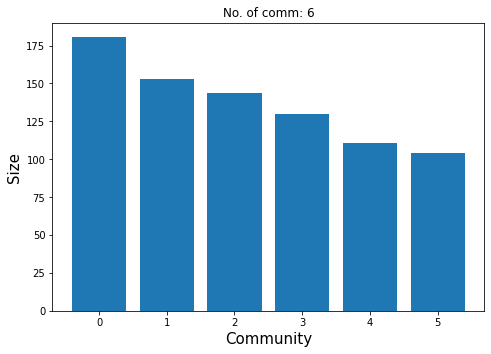

	 Processing subcommunity number 1.0


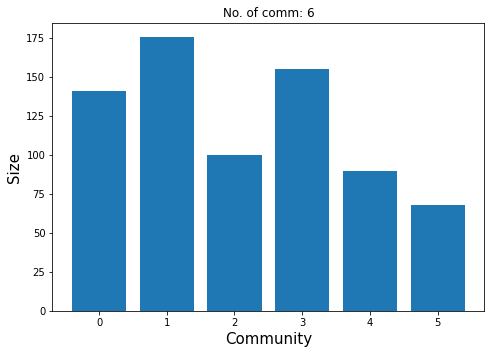

	 Processing subcommunity number 2.0


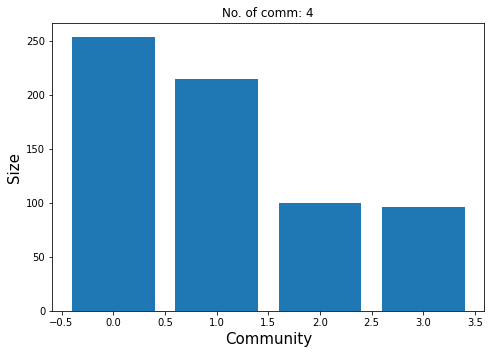

	 Processing subcommunity number 3.0


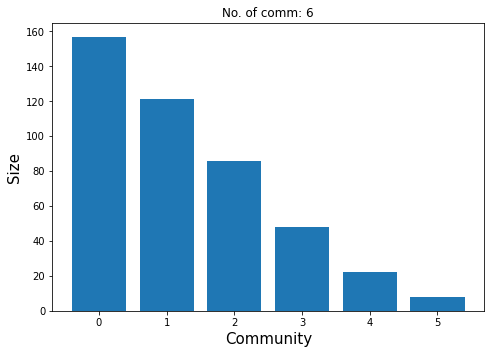

	 Processing subcommunity number 4.0


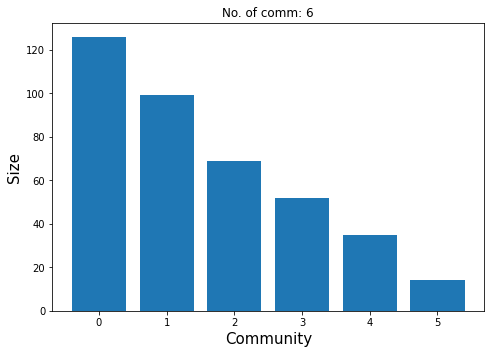

	 Processing subcommunity number 5.0


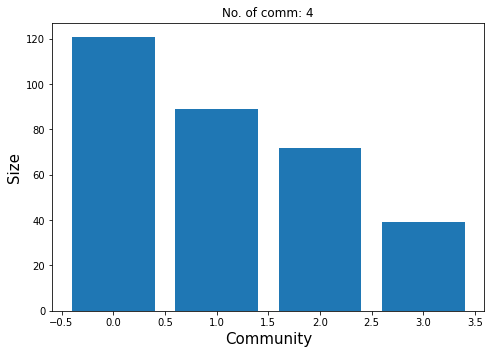

	 Processing subcommunity number 6.0


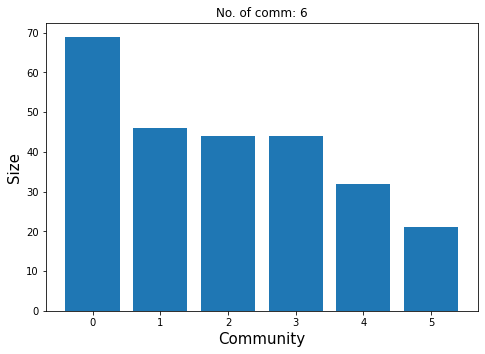

	 Processing subcommunity number 7.0


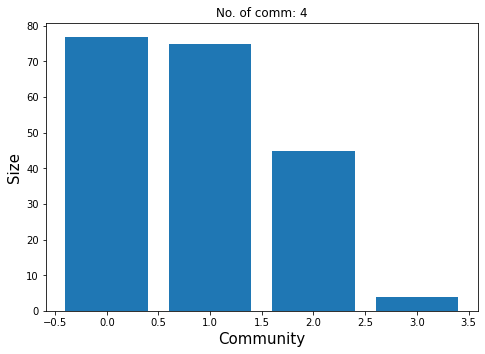

	 Processing subcommunity number 8.0


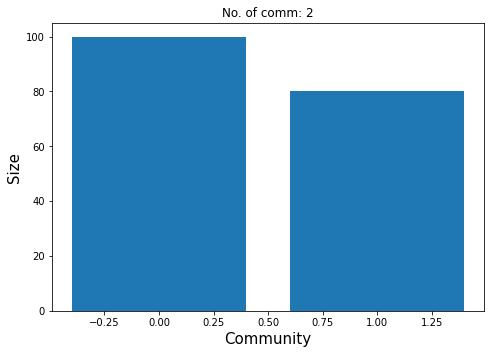

Processing community number 1
	 Processing subcommunity number 0.0


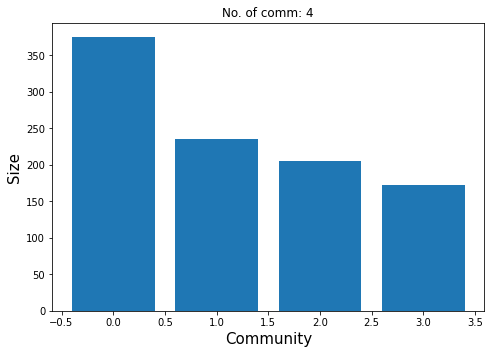

	 Processing subcommunity number 1.0


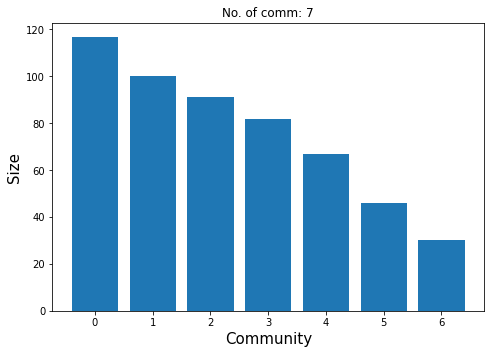

	 Processing subcommunity number 2.0


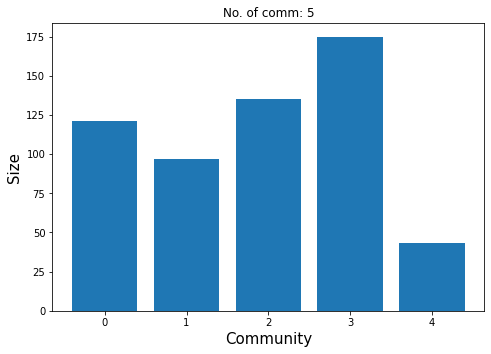

	 Processing subcommunity number 3.0


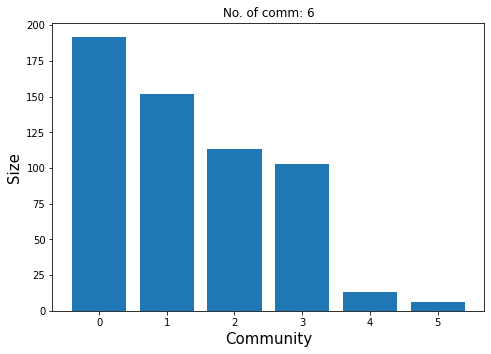

	 Processing subcommunity number 4.0


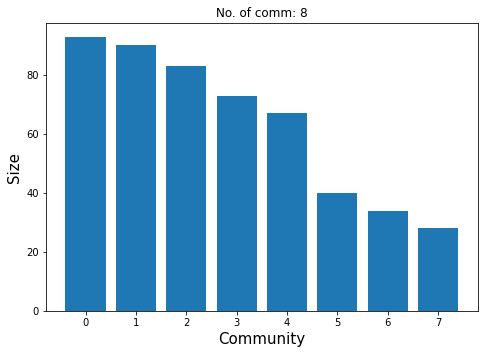

	 Processing subcommunity number 5.0


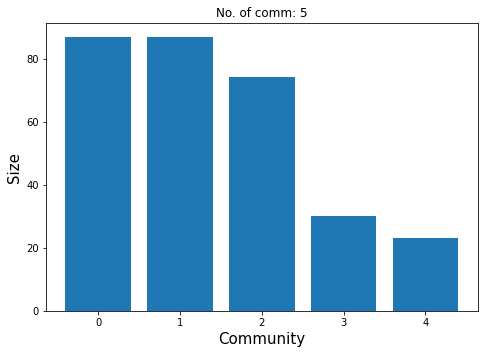

	 Processing subcommunity number 6.0


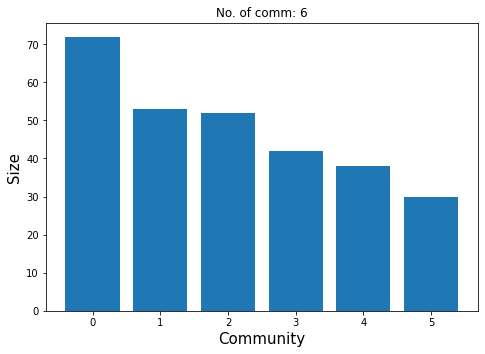

	 Processing subcommunity number 7.0


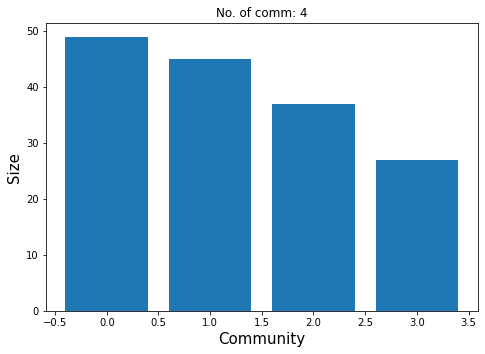

Processing community number 2
	 Processing subcommunity number 0.0


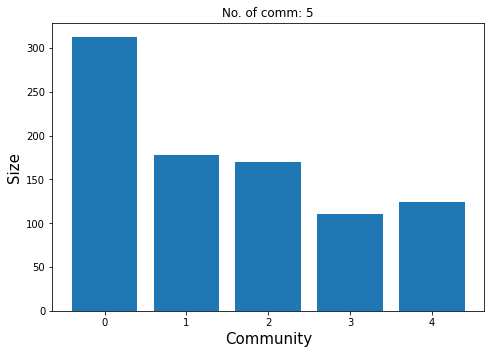

	 Processing subcommunity number 1.0


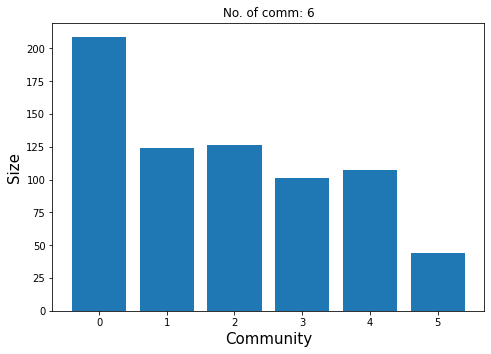

	 Processing subcommunity number 2.0


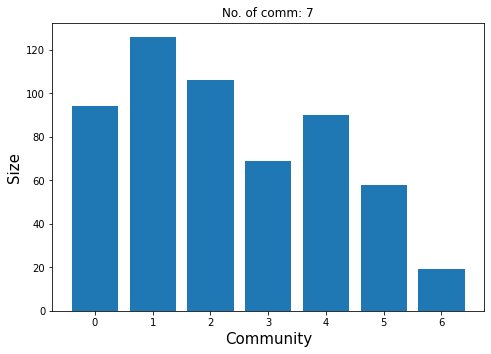

	 Processing subcommunity number 3.0


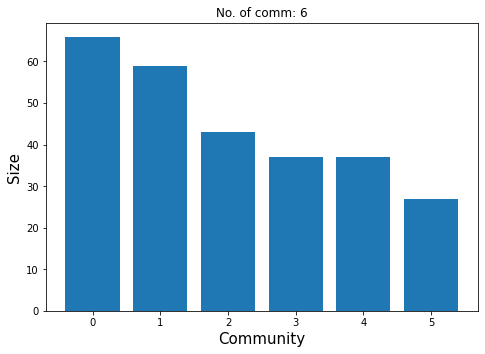

	 Processing subcommunity number 4.0


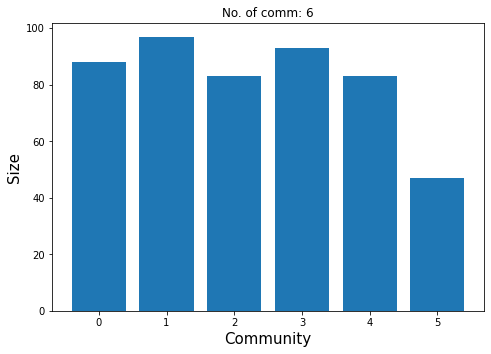

	 Processing subcommunity number 5.0


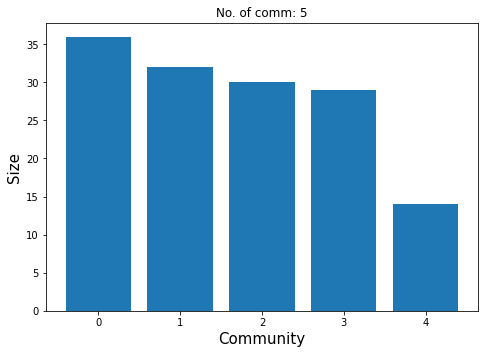

Processing community number 3
	 Processing subcommunity number 0.0


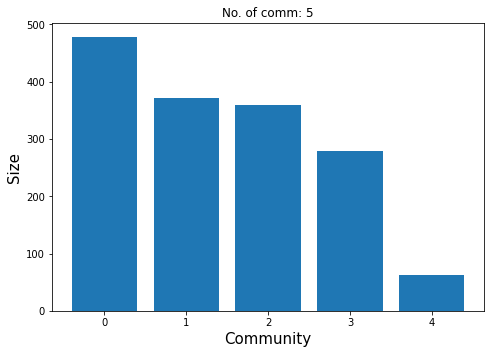

	 Processing subcommunity number 1.0


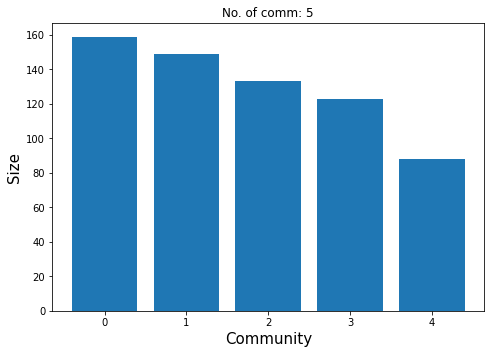

	 Processing subcommunity number 2.0


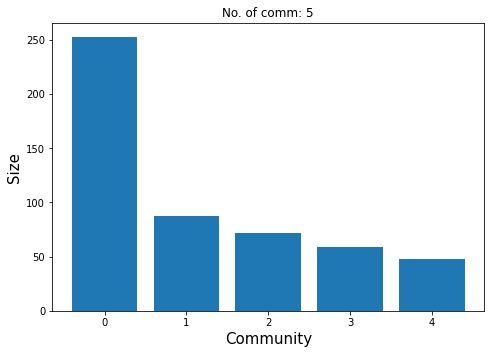

	 Processing subcommunity number 3.0


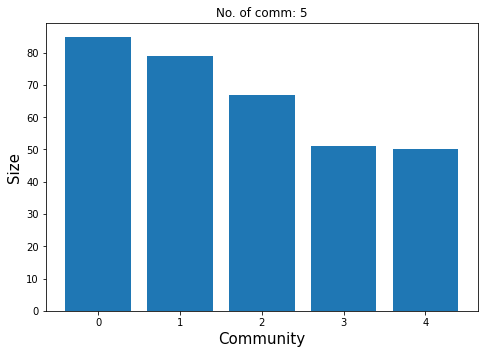

	 Processing subcommunity number 4.0


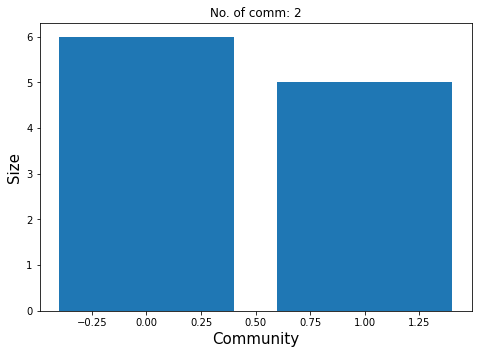

Processing community number 4
	 Processing subcommunity number 0.0


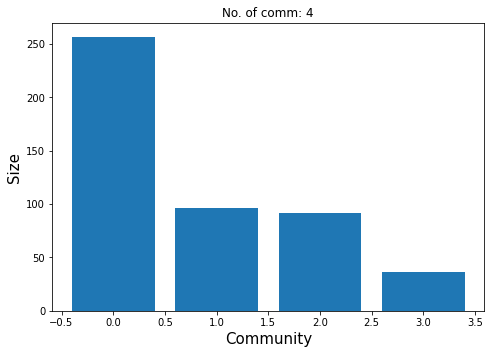

	 Processing subcommunity number 1.0


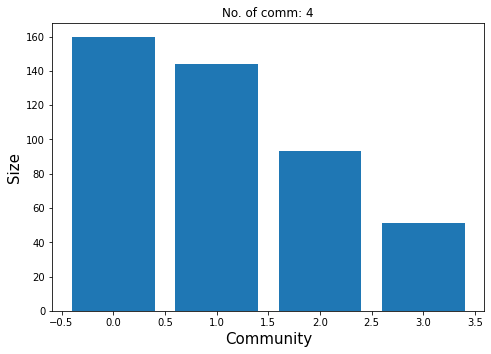

	 Processing subcommunity number 2.0


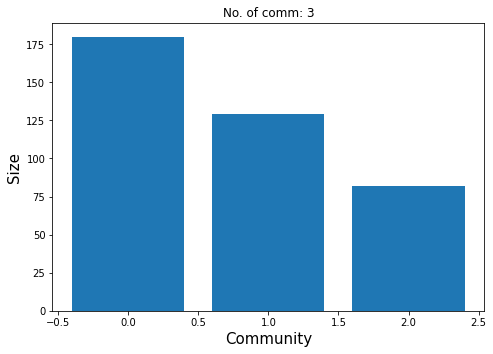

	 Processing subcommunity number 3.0


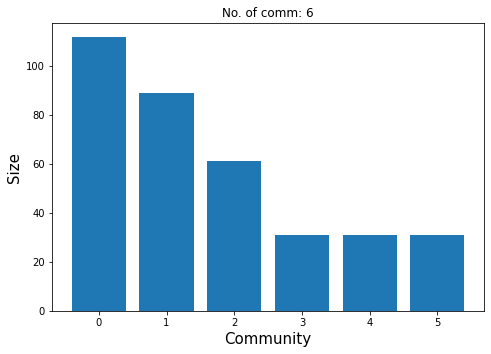

	 Processing subcommunity number 4.0


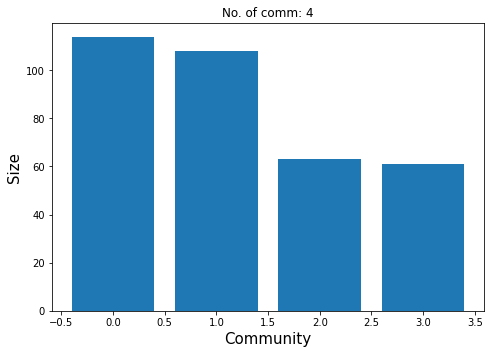

	 Processing subcommunity number 5.0


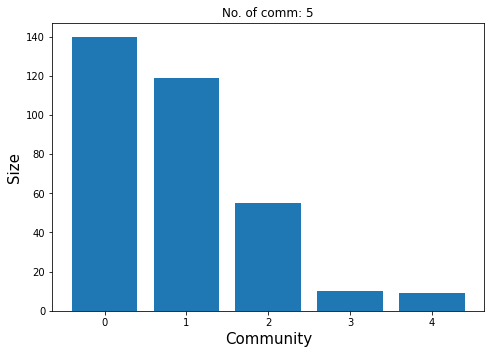

Processing community number 5
	 Processing subcommunity number 0.0


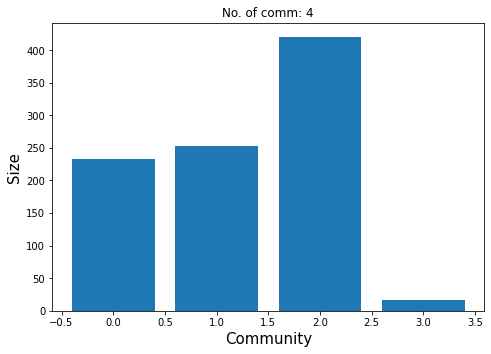

	 Processing subcommunity number 1.0


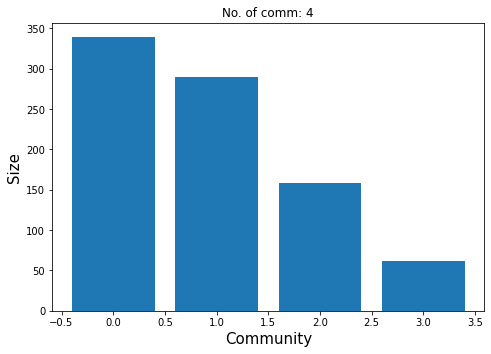

	 Processing subcommunity number 2.0


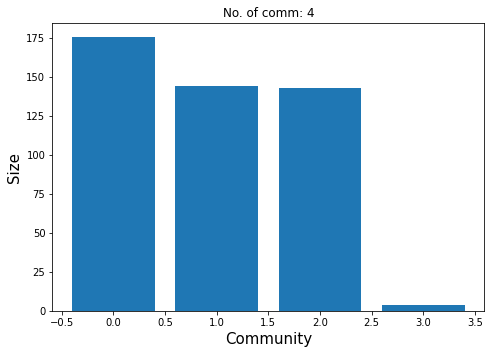

	 Processing subcommunity number 3.0


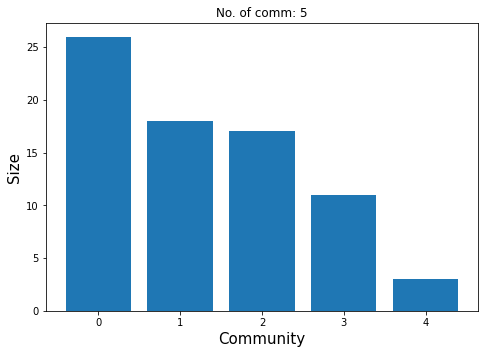

Processing community number 6
	 Processing subcommunity number 0.0


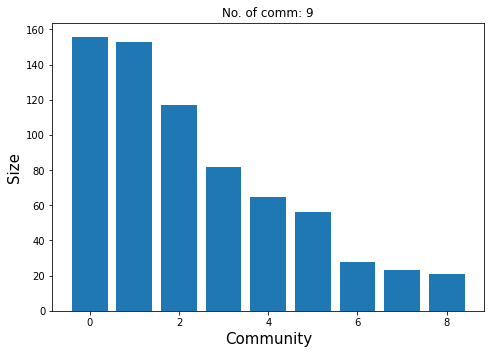

	 Processing subcommunity number 1.0


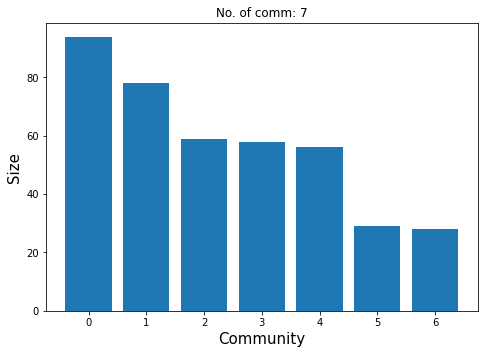

	 Processing subcommunity number 2.0


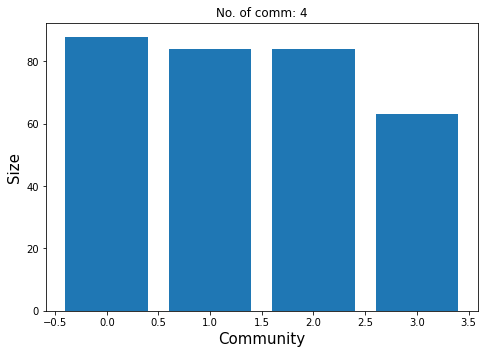

	 Processing subcommunity number 3.0


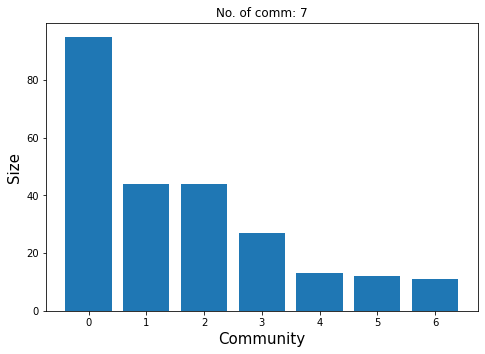

	 Processing subcommunity number 4.0


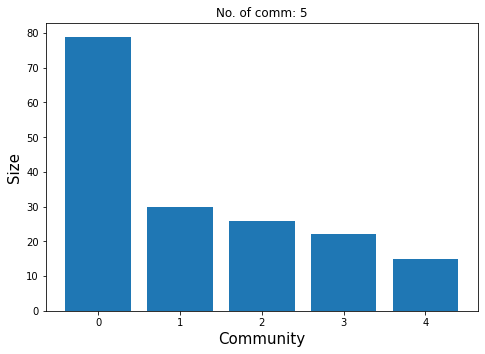

	 Processing subcommunity number 5.0


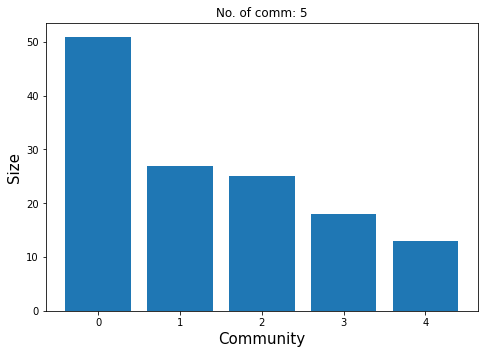

	 Processing subcommunity number 6.0


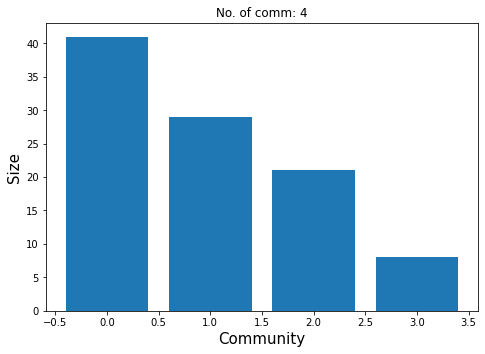

Processing community number 7
	 Processing subcommunity number 0.0


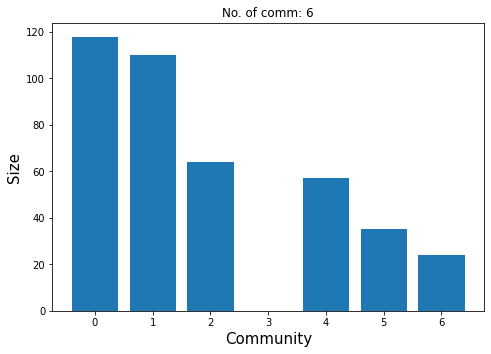

	 Processing subcommunity number 1.0


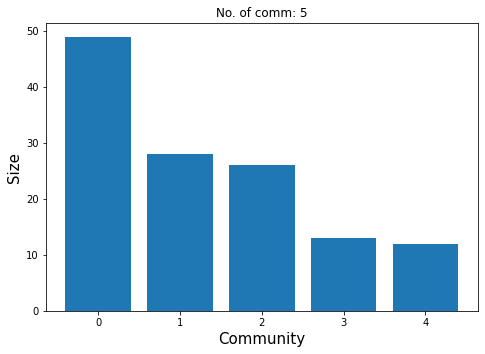

	 Processing subcommunity number 2.0


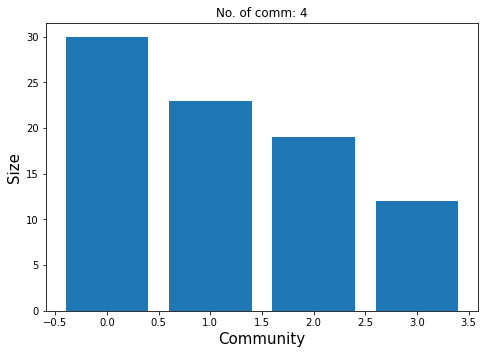

	 Processing subcommunity number 3.0


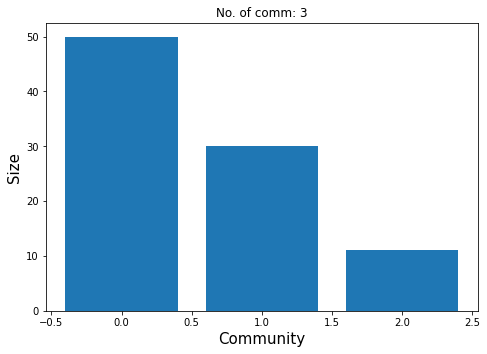

	 Processing subcommunity number 4.0


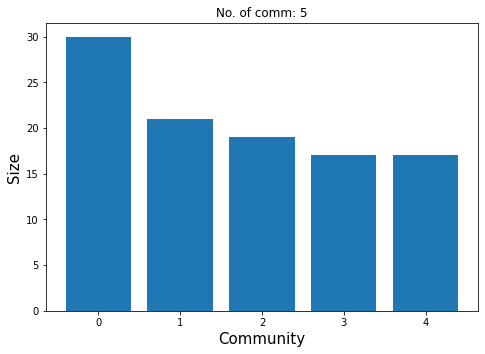

	 Processing subcommunity number 5.0


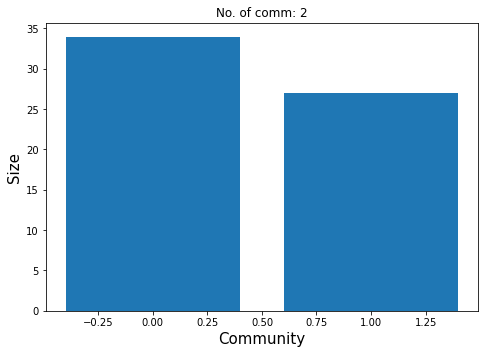

	 Processing subcommunity number 6.0


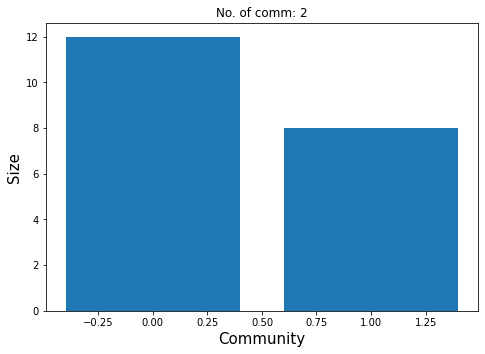

	 Processing subcommunity number 7.0


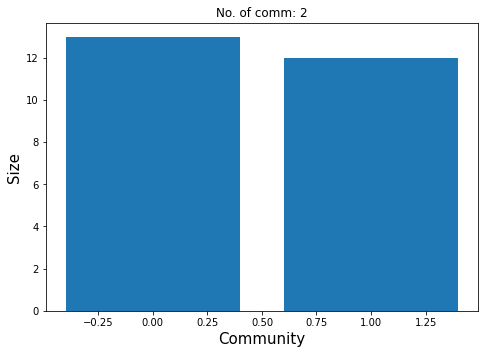

CPU times: user 1min 17s, sys: 46 s, total: 2min 3s
Wall time: 4min 59s


In [18]:
%%time

idx_comm=0
n_comm = len(np.unique(final_communities_all)) 

for idx_comm in range(n_comm):
    df_sub = pd.read_csv("./EM_communities/averageSubComm%d_drosophilia.csv"%(idx_comm))
    ss_comm_list = np.unique(df_sub.Community.tolist())
    
    print("Processing community number", idx_comm)
    
    for ss_comm in ss_comm_list:
        print("\t Processing subcommunity number", ss_comm)
        
        ss_nodes = df_sub[df_sub.Community==ss_comm]["Node"]
        df_ss = df.loc[(df['bodyId_pre'].isin(ss_nodes)) & (df['bodyId_post'].isin(ss_nodes))]
        nodeA_list = df_ss.bodyId_pre.tolist()
        nodeB_list = df_ss.bodyId_post.tolist()
        weight_list = df_ss.weight.tolist()
        G_ss_nx = construct_G(nodeA_list, nodeB_list, weight_list)

        # create folder
        if not os.path.exists("./EM_communities/averageSubComm%d/"%idx_comm):
            # if the demo_folder directory is not present 
            # then create it.
            os.makedirs("./EM_communities/averageSubComm%d/"%idx_comm)

        # sub sub communities
        G_ss_ig = ig.Graph.from_networkx(G_ss_nx)

        num_comm_tofind = find_number_communities(G_ss_ig)

        def subcommunities_loop(args):
            nreps, seed = args
            np.random.seed(seed)

            list_communities = []
            while len(list_communities) < nreps:
                dir_leiden = leidenalg.find_partition(G_ss_ig, leidenalg.ModularityVertexPartition, weights="weight")
                if np.unique(dir_leiden.membership).size == num_comm_tofind:
                    list_communities.append(dir_leiden.membership)

            return list_communities

        nloops = 32
        seeds = np.random.randint(0, int(1e6), size = nloops)

        with ProcessPoolExecutor() as executor:
            parallel_res = executor.map(subcommunities_loop,
                                        zip([32]*nloops,
                                            seeds))
        list_communities = []
        for res in parallel_res:
            [list_communities.append(i) for i in res]

        idx_communities = np.array(list(range(num_comm_tofind)))
        comm_truth = find_communities(list_communities[0], idx_communities)

        relabeled_comm_list = []
        for idx in range(len(list_communities)):
            relabeled_comm_list.append(relabel_communities(idx, comm_truth,
                                                           list_communities, idx_communities))

        relabeled_comm_list = np.array(relabeled_comm_list).astype(np.int8)

        final_communities = np.empty(relabeled_comm_list.shape[1])
        for idx, rep in enumerate(relabeled_comm_list.T):
            final_communities[idx] = np.bincount(rep).argmax()


        Community_save(G_ss_ig, final_communities, f"./EM_communities/averageSubComm{idx_comm}/average_SS_Comm{ss_comm}")